# Model Ranking and Select the Best Model
- Aggregates evaluation results from all trained models -

    - Arima (auto_arima optimization)
    - XGBoost (optuna optimization)
    - LSTM (Neural Network)

- compares their performance metrics and identifies the best-performing model.

Once the best model is selected, we'll performs error analysis and visualizes performance through plots.

- Purpose:

    - Provide a unified comparison of all candidate models
    - Select the most suitable model for deployment
    - Conduct error analysis and performance visualization for the chosen model

# Root Configuration

In [1]:
import sys
import os
from pathlib import Path

# get project root as parent of current working directory
project_root = Path(os.getcwd()).parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import load_model

from yellowbrick.regressor import PredictionError, ResidualsPlot

from pathlib import Path

# Model Comparison

## Metrics Overview

In [3]:
# model performance path
model_performance_dir = Path(r"../artifacts/model-performance")

# performance files
model_performance = pd.read_csv(model_performance_dir / "a_ModelPerformance.csv")
overfitting_analysis = pd.read_csv(model_performance_dir / "a_OverfittingAnalysis.csv")

In [4]:
# Table 1: All Models Performance
print("=== TABLE 1: OVERALL MODELS PERFORMANCE ===".center(110))
display(model_performance)

                                 === TABLE 1: OVERALL MODELS PERFORMANCE ===                                  


,Model,Test MAE,Test R2-Score,Test MAPE,CV MAE,CV R2,CV MAPE,RMSE Increase,Overfitting Ratio
0,Arima,24.663,-0.071,12.540,121.647,-48.653,84.104,-104.375,0.234
1,XGBoost,53.752,-4.351,38.378,6.272,0.294,9.406,49.399,5.913
2,LSTM,7.595,0.919,4.117,0.070,-0.191,12.897,8.624,101.567


In [5]:
# Table 2: Overfitting Analysis
print("=== TABLE 2: OVERFITTING ANALYSIS ===".center(70))
display(overfitting_analysis)

                === TABLE 2: OVERFITTING ANALYSIS ===                 


,Model,CV_RMSE,Test_RMSE,RMSE_Increase,Overfitting_Ratio
0,Arima,136.202,31.828,-104.375,0.234
1,XGBoost,10.055,59.453,49.399,5.913
2,LSTM,0.086,8.710,8.624,101.567


In [6]:
# models ranking based on Test MAPE, Test MAE, CV MAPE
model_ranking = model_performance.sort_values(by=['Test MAPE', 'Test MAE', 'CV MAPE'], ascending=True).reset_index(drop=True)

print("=== TABLE 3: MODELS RANKING ===".center(110))
display(model_ranking)


                                       === TABLE 3: MODELS RANKING ===                                        


,Model,Test MAE,Test R2-Score,Test MAPE,CV MAE,CV R2,CV MAPE,RMSE Increase,Overfitting Ratio
0,LSTM,7.595,0.919,4.117,0.070,-0.191,12.897,8.624,101.567
1,Arima,24.663,-0.071,12.540,121.647,-48.653,84.104,-104.375,0.234
2,XGBoost,53.752,-4.351,38.378,6.272,0.294,9.406,49.399,5.913


## Cmparitive Visualization

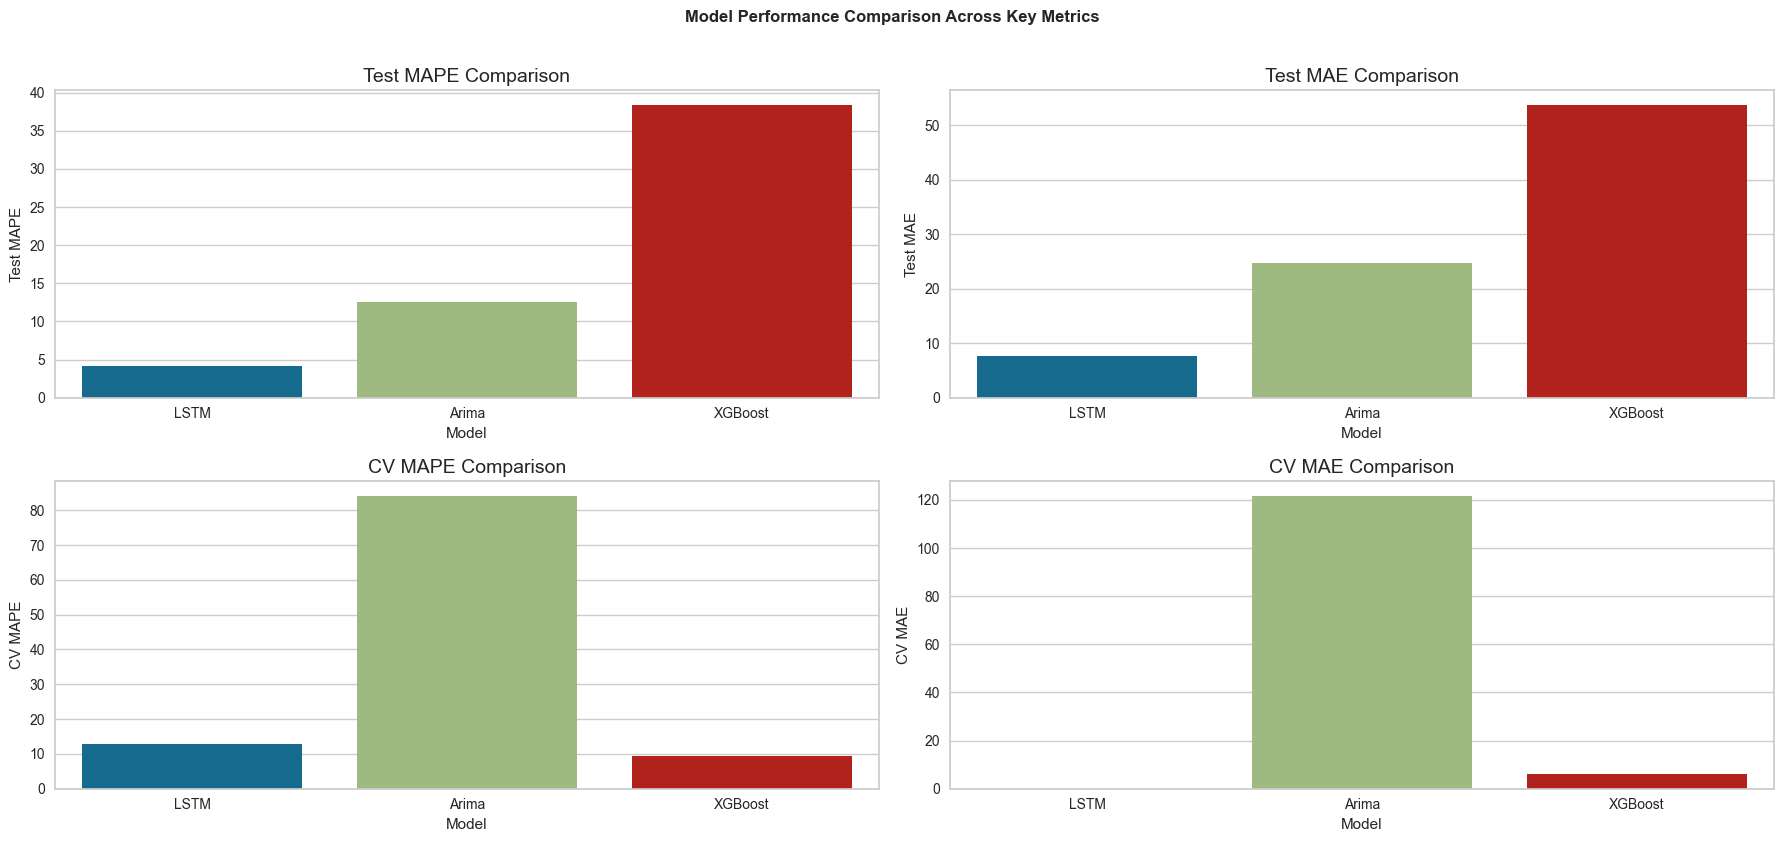

In [7]:
""" Bar Plot: Compare MAPE, MAE, RMSE across models """

metrics_to_plot = ['Test MAPE', 'Test MAE', 'CV MAPE',  'CV MAE']               # define the key evaluation metrics to visualize
model_names = model_ranking['Model']                                            # extract model names from the ranking DataFrame

fig, axes = plt.subplots(2, 2, figsize=(18, 8))                                 # 2 rows and 2 columns
axes = axes.flatten()                                                           # 2x2 grid

# loop through each metric and create a separate barplot
for i, metric in enumerate(metrics_to_plot):
    sns.barplot(data=model_ranking, x='Model', y=metric, ax=axes[i], hue='Model', legend=False)         # performance bar chart
    
    axes[i].set_title(f'{metric} Comparison', fontsize=14)                                              # chart title
    axes[i].set_ylabel(metric)                                                                          # metric label on y-axis

plt.tight_layout()                                                                                            # Adjust layout to prevent overlapping
plt.suptitle("Model Performance Comparison Across Key Metrics", fontsize=12, fontweight='bold', y=1.05)       # overall title for the figure
plt.show()

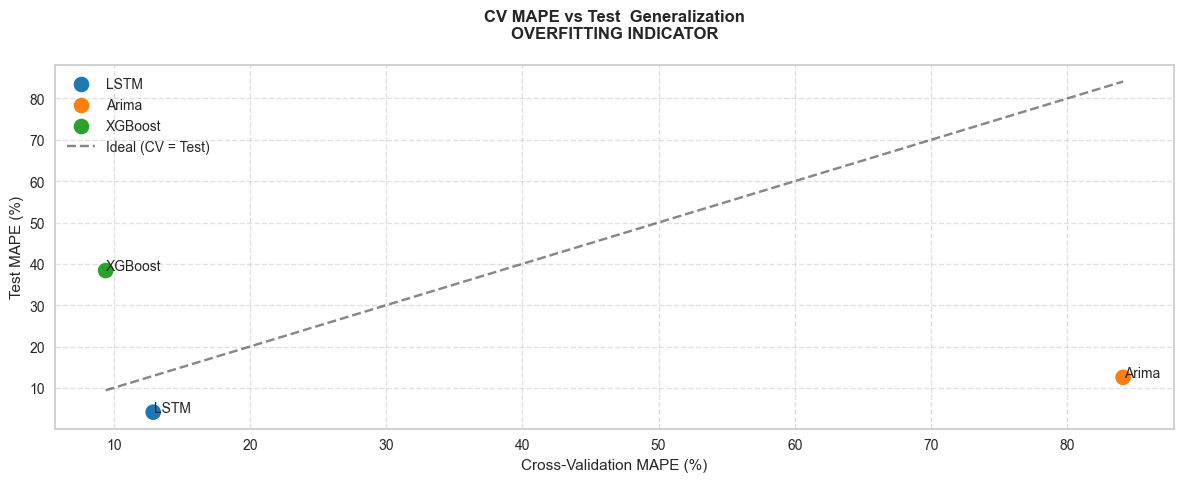

In [8]:
""" Scatter Plot: Cross-Validation MAPE vs Test MAPE (Generalization Check) """

# figure size
plt.figure(figsize=(12, 5))

# scatter plot to compare Cross-Validation MAPE and Test MAPE across models
sns.scatterplot(
    data=model_ranking,
    x='CV MAPE',
    y='Test MAPE',
    hue='Model',
    s=150,
    palette='tab10'
)

# annotate each point with the corresponding model name
for idx, row in model_ranking.iterrows():
    plt.text(
        row['CV MAPE'] + 0.05,
        row['Test MAPE'],
        row['Model'],
        fontsize=10,
        ha='left'
    )

# plot a reference diagonal line representing perfect generalization
plt.plot([model_ranking['CV MAPE'].min(), model_ranking['CV MAPE'].max()],
         [model_ranking['CV MAPE'].min(), model_ranking['CV MAPE'].max()],
         'k--', alpha=0.5, label='Ideal (CV = Test)')

# label the axes
plt.xlabel('Cross-Validation MAPE (%)')
plt.ylabel('Test MAPE (%)')
plt.title('CV MAPE vs Test  Generalization\nOVERFITTING INDICATOR', fontsize=12, fontweight='bold', y=1.05)

# light dashed grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Summary Of The Best Model

In [9]:
print("=== Performance Summary of The Best Model ===")
model_ranking.iloc[0]

=== Performance Summary of The Best Model ===


Model                   LSTM
Test MAE               7.595
Test R2-Score          0.919
Test MAPE              4.117
CV MAE                  0.07
CV R2                 -0.191
CV MAPE               12.897
RMSE Increase          8.624
Overfitting Ratio    101.567
Name: 0, dtype: object